# Imports

In [69]:
import pickle
import numpy as np
import warnings
import healpy as hp
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from scipy.interpolate import RegularGridInterpolator
warnings.filterwarnings("ignore")


In [70]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [71]:
from matplotlib.colors import LogNorm
plt.set_cmap("cividis")

<Figure size 640x480 with 0 Axes>

# Source parameters

In [72]:
pi0_norm = 5.47e-13 #1.9e-16 #2.43e-18  #unbias corrected bias corrected 2.18e-18 #1/(GeV s  cm^2)
pi0_spectrum = 2.7
E0 = 1e3
LIVETIME = 10 * 365 * 86400
'''
pi0_norm = 2.18e-18 #1.9e-16 #2.43e-18  #unbias corrected bias corrected 2.18e-18 #1/(GeV s  cm^2)
pi0_spectrum = 2.7
E0 = 1e5
LIVETIME = 10 * 365 * 86400'''

'\npi0_norm = 2.18e-18 #1.9e-16 #2.43e-18  #unbias corrected bias corrected 2.18e-18 #1/(GeV s  cm^2)\npi0_spectrum = 2.7\nE0 = 1e5\nLIVETIME = 10 * 365 * 86400'

In [73]:
base_dir = '/home/ssclafani/pone/data/'

In [74]:
nside= 128

In [75]:
pi0_weight_per_bin = np.load(base_dir + 'Fermi-LAT_pi0_map.npy', encoding='latin1')
pi0_weight_per_bin /= pi0_weight_per_bin.sum()
print(sum(pi0_weight_per_bin))
if nside != 128:
    print('NSIDE: {}'.format(nside))
    pi0_weight_per_bin = hp.ud_grade(pi0_weight_per_bin, nside)
    
pi0_flux_per_pixel = pi0_norm * pi0_weight_per_bin #* hp.nside2pixarea(nside) 

0.9999999999999891


In [76]:
sum(pi0_flux_per_pixel)

5.469999999999917e-13

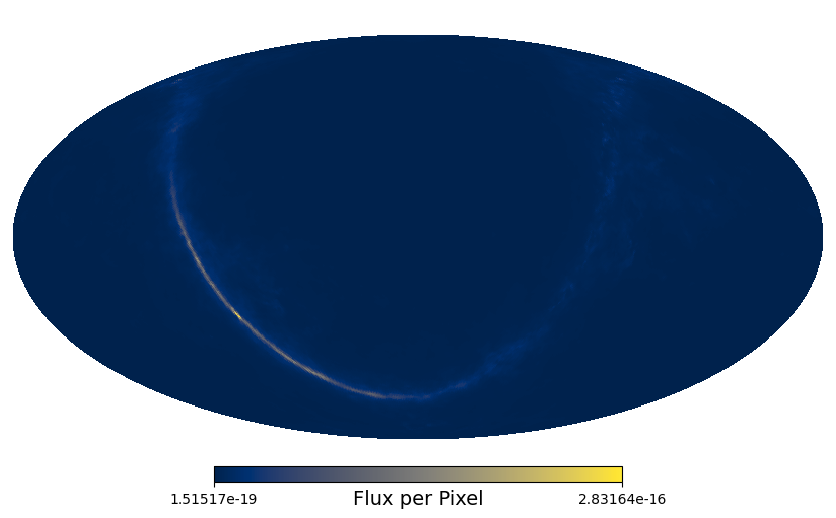

In [77]:
hp.mollview (pi0_flux_per_pixel, unit='Flux per Pixel', rot=(180,0), title=' ')

# Functions

In [78]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [79]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in true energy to reconstructed energy"""
    return (ematrix @ ev.T).T

In [80]:
def atmo_background(aeff_factor_bckg, bckg_flux_vals, smear_energy=False, smooth_bkg=False):
    """Calculate the number of neutrinos of atmospheric background flux as a function reconstructed energy"""
    if smear_energy:
        return energy_smearing(normed_kvals, aeff_factor_bckg * bckg_flux_vals)
    else:
        if smooth_bkg:
            return aeff_factor_bckg *smoothed_bkg
        else:
            
            return aeff_factor_bckg * bckg_flux_per_pixel

In [81]:
def array_source_interp(dec, array):
    """Take a 2D array and interpolate its values
    based on a value (dec) on the second axis"""
    low_ind = np.digitize(np.sin(dec), coszen_bins) - 1

    if low_ind >= (len(coszen_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if coszen_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [coszen_mids[low_ind], coszen_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


# Get the effective area

In [82]:
h2d = np.load('/home/ssclafani/pone/data/PONE_nu_effa_70_string.npy', allow_pickle=True)[()]
#h2d = np.load(base_dir + 'pstracks_nu_effa.npy', allow_pickle=True)[()]
h2d

Hist(25 bins in [2.0,7.000000000000004], 49 bins in [-1.0,1.0], with sum 73844.22012624066, 113 empty bins, and 0 non-finite values)

In [85]:
logE_bins = h2d.bins[0]
coszen_bins = h2d.bins[1]
aeff_2d = 1e4*h2d.values #values are in m^2 not cm^2 ?? is this necessary?

In [86]:
# use only upgoing data to mimick up-going muon track data set
#with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
#    logE_bins, sindec_bins, aeff_2d = pickle.load(f)
#h2d = np.load('/home/steve/pone/data/PONE_nu_effa_70_string.npy')
#logE_bins = h2d.bins

logE_mids = get_mids(logE_bins)
# cut at E=10⁹GeV
logE_bins = logE_bins
aeff_2d = aeff_2d
logE_mids = logE_mids


ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

coszen_mids = get_mids(coszen_bins)
coszen_width = np.diff(coszen_bins)

print(len(emids), "log_10(energy) bins")
print(len(coszen_mids), "declination bins")


25 log_10(energy) bins
49 declination bins


(2.0, 7.0)

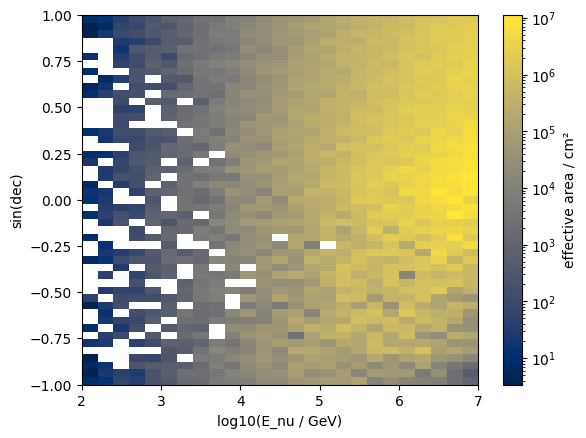

In [87]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

# Background

In [88]:
# MCEQ
with open('/home/ssclafani/pone/software/Plenum/resources//MCEq_flux.pckl', "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"] + flux_def["mu_total"])
)
# baseline evaluation
ss, em = np.meshgrid(coszen_mids, emids)
bckg_flux_vals = np.exp(rgi((em, ss))).T

(2.0, 7.0)

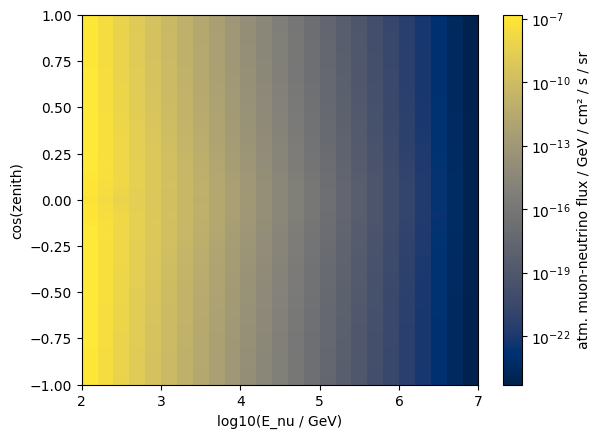

In [89]:
plt.pcolormesh(logE_bins, coszen_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("cos(zenith)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

In [90]:
bckg_flux_vals.shape

(49, 25)

# Source flux definition

In [91]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
    PHI_0,
    smear_energy=True
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-14
    """
    if hasattr(PHI_0, "__len__"):
        tmp = np.array([aeff_factor[i] * (emids/E0)**(-gamma) * phi * phi_scaling for i, phi in enumerate(PHI_0)])
    else:
        tmp = aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling
    #print(tmp.shape)
    if smear_energy:
        return energy_smearing(normed_kvals, tmp)
    else:
        return tmp

In [92]:
effa_template = np.ndarray((hp.nside2npix(nside), len(emids)))
bckg_flux_per_pixel = np.ndarray((hp.nside2npix(nside), len(emids)))

#reshape effective area in nbins vs energy
for pix, flux in enumerate(pi0_flux_per_pixel):
    theta, phi = hp.pix2ang(nside, pix)
    dec = np.pi/2 - theta
    ra = phi
    sindec = np.sin(dec)
    
    effa_template[pix] = array_source_interp(-dec, aeff_2d)
    bckg_flux_per_pixel[pix] = array_source_interp(-dec, bckg_flux_vals.T)
    
smoothed_bkg = np.ndarray((hp.nside2npix(nside), len(emids)))
for i in range(len(emids)):
    smoothed_bkg[:,i] = hp.smoothing(bckg_flux_per_pixel[:,i], sigma=np.radians(10))


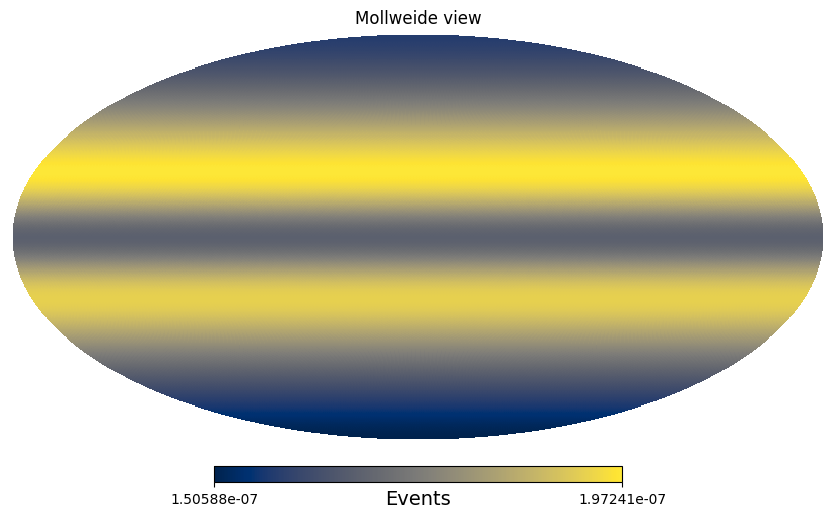

In [117]:
hp.mollview(np.sum(smoothed_bkg, axis=1), rot=(180,0), unit='Events')

In [93]:
bckg_flux_per_pixel.shape

(196608, 25)

In [94]:
k_s = []
aeff_factor_signal = (
    effa_template*  LIVETIME * ewidth #* e_psi2_grid
    )    
print(aeff_factor_signal.shape)

k_s = astro_flux(
    aeff_factor_signal, #what to do here?  
    emids,
    E0,
    pi0_spectrum,
    1,
    PHI_0=pi0_flux_per_pixel,
    smear_energy=False,
)
print(k_s.shape)


(196608, 25)
(196608, 25)


In [95]:
k_s.sum()

345.3351700737485

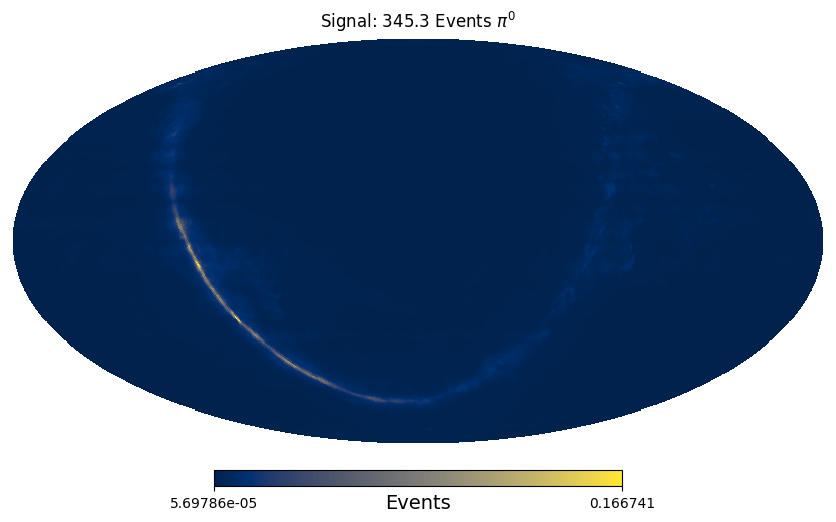

In [96]:
hp.mollview(np.sum(k_s, axis=1), rot=(180,0), unit='Events',title='Signal: {:.1f} Events $\pi^0$'.format(k_s.sum()))

In [97]:
##smear the template with ang unc bins
angres = np.linspace(1,.05,25)

In [98]:
smeared_template = np.ndarray((hp.nside2npix(nside), len(emids)))
for i, angerr in enumerate(angres):
    print('Smearing template for Energy {:2f}: {:.1f} deg'.format(emids[i], angerr), flush=True, end='\r')
    template = k_s[:,i]
    smeared_template[:,i] = hp.smoothing(template, sigma=np.radians(angerr))

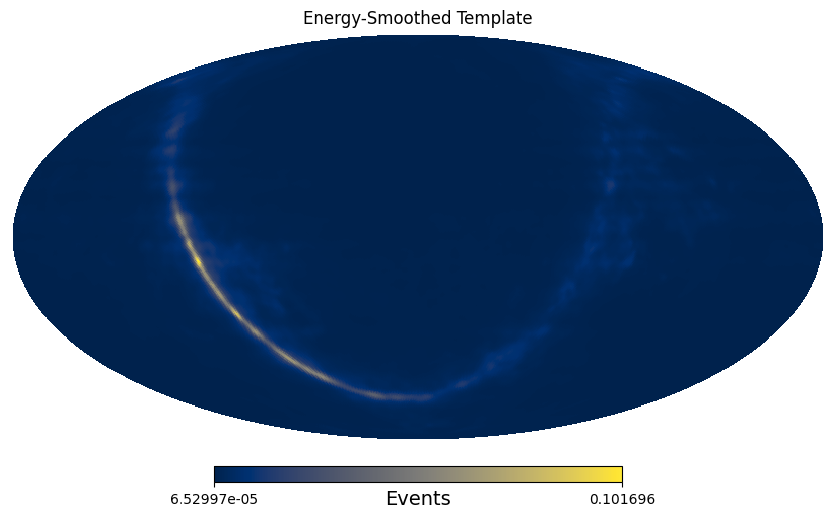

In [99]:
hp.mollview(np.sum(smeared_template, axis=1), unit='Events',rot=(180,0), title='Energy-Smoothed Template')

In [100]:
### bkg_b

In [101]:
aeff_factor_bckg = (
        effa_template
        * LIVETIME
        * ewidth
        * hp.nside2pixarea(nside, degrees=False) # solid angle approx. 2x?
    )#* bckg_grid * 1
print(aeff_factor_bckg.shape)
k_b = atmo_background(aeff_factor_bckg , bckg_flux_per_pixel, smear_energy=False, smooth_bkg=True)
#k_b = atmo_background(aeff_factor_bckg, array_source_interp(dec, bckg_flux_vals.T).T)

(196608, 25)


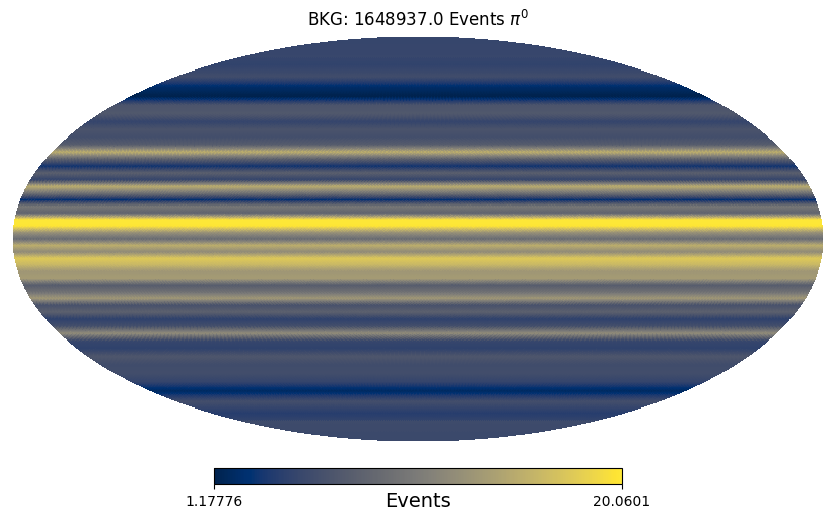

In [102]:
hp.mollview(np.sum(k_b, axis=1), rot=(180,0),unit='Events', title='BKG: {:.1f} Events $\pi^0$'.format(k_b.sum()))

In [103]:
k_b.sum()

1648936.9586100646

In [104]:
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

In [105]:
k_i = k_b + smeared_template

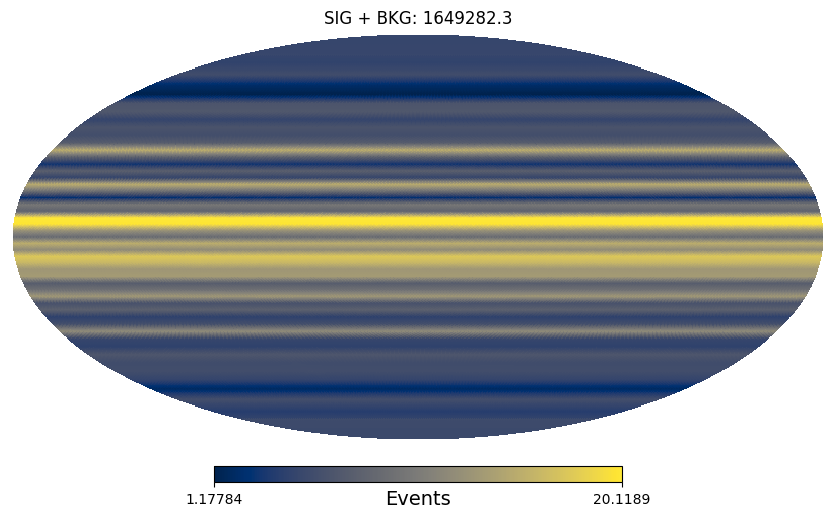

In [106]:

hp.mollview( np.sum(k_i, axis=1), rot=(180,0), unit='Events',  title='SIG + BKG: {:.1f}'.format(k_i.sum()))
plt.tight_layout()

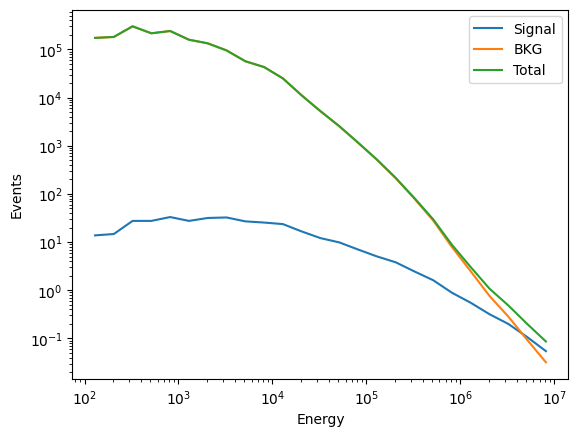

In [107]:
plt.plot(emids, np.sum(smeared_template, axis=0), label='Signal')
plt.plot(emids, np.sum(k_b, axis=0), label='BKG')
plt.plot(emids, np.sum(k_i, axis=0), label='Total')

plt.loglog()
#plt.title('Signal Events')
plt.xlabel('Energy')
plt.ylabel('Events')
plt.legend()

In [108]:
mu_b_base.shape
mu_s_base.shape
bckg_flux_per_pixel.shape

(196608, 25)

In [109]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
    verbose=False
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """
    if verbose:
        print(x)
    mu_b = atmo_background(
        x[0]*mu_b_base, bckg_flux_per_pixel, smear_energy=False, smooth_bkg=True
    )

    mu_s = astro_flux(
        mu_s_base, emids, e_0, pi0_spectrum, x[1], PHI_0=pi0_flux_per_pixel, smear_energy=False
    )
    #print(mu_b.shape, mu_s.shape)
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (B/S)
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i,
            #- 0.5 * np.log(2 * np.pi * k_i)
            #+ k_i
            #- k_i * np.log(k_i),
            0,
        )
    )
    

In [110]:
from scipy.optimize import minimize

In [111]:
# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 0), mu_b_base, mu_s_base, k_i
)
# background + signal, 3 free parameters

# ... and fit both hypotheses!
out_bckg = minimize(
    local_llh,
    x0=(1.2,),
    options={'maxiter' : 100}
    #epsilon=.01,
    #approx_grad=True,
    
)

print('Function Calls: {}'.format(out_bckg['nfev']))

#print(out_bckg)
print("Bckg-only normalization:", out_bckg['x'])
global_llh = lambda x: ps_llh_2d_composite(
    (x), mu_b_base, mu_s_base, k_i
)


out_comp = minimize(
    global_llh,
    #epsilon=(.0001, .5),
    x0=(1.1,  0.5),
    options={'maxiter' : 200}
    #approx_grad=True,
)
#print(out_comp)
print('Function Calls: {}'.format(out_comp['nfev']))

print("Signal fit parameters:", out_comp['x'])

# calculate p-value and significance with Wilks' and -2- 1 d.o.f
pval = chi2.sf(out_bckg['fun'] - out_comp['fun'], 2)

significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE: {:.6f}".format(pval), "SIGNIFICANCE: {:.3f}".format(significance))


Function Calls: 30
Bckg-only normalization: [1.00020888]
Function Calls: 54
Signal fit parameters: [1.00000839 0.95733148]
P-VALUE: 0.034776 SIGNIFICANCE: 2.111


In [112]:
sig_llh = []
xs = np.linspace(0,1.5,25)
for x in xs:
    sig_llh.append(ps_llh_2d_composite(
        (1,x), mu_b_base, mu_s_base, k_i
    ))

Text(0.5, 0, 'Sig Norm')

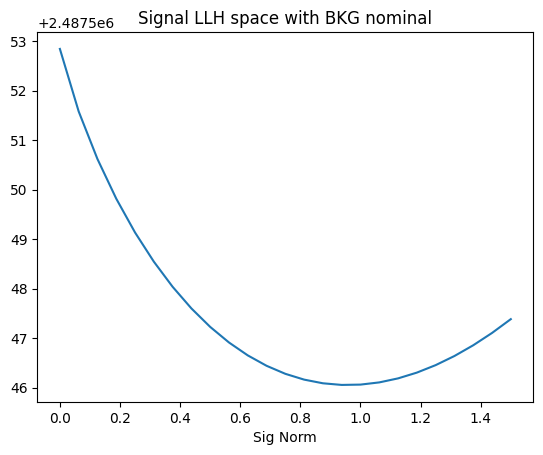

In [113]:
plt.plot(xs, np.array(sig_llh))
plt.title('Signal LLH space with BKG nominal')
plt.xlabel('Sig Norm')

In [114]:
bkg_llh = []
xs = np.linspace(.1,2,25)
for x in xs:
    bkg_llh.append(ps_llh_2d_composite(
        (x,0), mu_b_base, mu_s_base, k_i
    ))

Text(0.5, 0, 'Bkg-Norm')

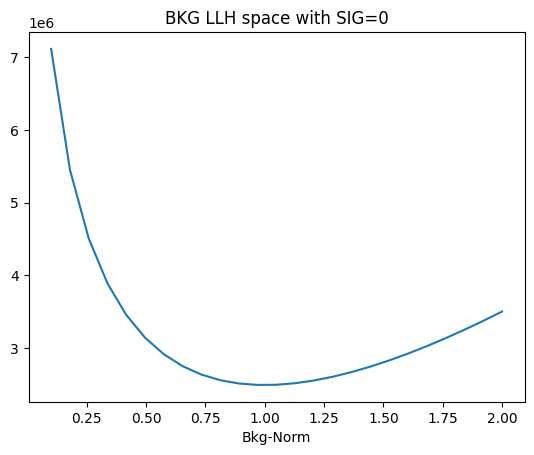

In [115]:
plt.plot(xs, np.array(bkg_llh))
plt.title('BKG LLH space with SIG=0')
plt.xlabel('Bkg-Norm')